# Shapiro Diagram with normalized parameters
### Cythonized, RF current in linear & log scale

## CPR of $I(\phi)=[\sin(\phi)+\eta\sin(2\phi)]+A(\sin(\phi+C)+\eta\sin[2(\phi+C)])$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import *
from scipy.io import savemat
from scipy.integrate import odeint
%matplotlib inline

In [2]:
%load_ext Cython

### Resistively Shunted Model:

$\frac{d\phi}{dt}=\frac{2eR_N}{\hbar}[I_{DC}+I_{RF}\sin(2\pi f_{RF}t)-I_C\sin\phi]$

Solving $\phi(t)$, then you can get the voltage difference between the superconducting leads:

$V=\frac{\hbar}{2e}\langle\frac{d\phi}{dt}\rangle$

After Normalizing:
$I_{DC}\leftrightarrow \tilde{I_{DC}}=I_{DC}/I_C$,

$I_{RF} \leftrightarrow \tilde{I_{RF}}=I_{RF}/I_C$,

$ V \leftrightarrow \tilde{V}=\frac{V}{I_CR_N}$,

$ R=\frac{dV}{dI} \leftrightarrow \tilde{R}=\frac{R}{R_N}$,


$\because f_0=2eI_CR_N/h$,

$f_{RF} \leftrightarrow \tilde{f_{RF}}=f_{RF}/f_0$,

$t \leftrightarrow \tilde{t}=f_0t$,

The Josephson voltage quantized at $\frac{V}{hf_{RF}f_0/2e}=n \leftrightarrow \frac{V}{f_{RF}f_0}=n$ 

Here, we can set $f_0=1$ or $\frac{I_CR_N}{hf_0/2e}=1$, without loss of generality

The RSJ model simply becomes (omitting $\tilde{}$):

$\frac{d\phi}{dt}=[I_{DC}+I_{RF}\sin(2\pi f_{RF}t)-\sin\phi]$

At equilibrium, $V=\frac{\hbar}{2e}\langle\frac{d\phi}{dt}\rangle \leftrightarrow \tilde{V}=\frac{1}{2\pi}\langle\frac{d\phi}{d\tilde{t}}\rangle$  would also quantized at integers in the Shapiro step regime.



### Cython codes here is to speed up the simulation because python is slower than C:

In [71]:
%%cython --pgo
#To use GNU compiler gcc-10 specified in .bash_profile

cimport numpy as np
from libc.math cimport sin, pi

### cdef is faster but can only be used for cython in this cell
#cpdef can be used for python outside this cell

cdef double CPR(double G, double A, double eta, double C):
    '''
        Current-phase relationship for the junction
    '''
    return sin(G)+eta*sin(2*G)+A*sin(G+C*pi)+A*eta*sin(2*G+2*C*pi)

cpdef double dGdt(G,double t,double i_dc,double i_ac,double f_rf,double A, double eta, double C):
    '''
        RSJ model
    '''
    der =  i_dc + i_ac * sin(2*pi*f_rf*t) - CPR(G,A,eta,C)
    return der 

In [127]:
A=0.2
eta=0.8
C=-0.8 # as a unit of pi
f_rf=0.4

In [128]:
IDC_step=0.1
IDC_array=np.linspace(-10,10,201)
IRF_step=0.1
IRF_array=np.linspace(0,15,151)

print("DC array size: "+str(len(IDC_array)))
print("RF array size: "+str(len(IRF_array)))



DC array size: 201
RF array size: 151


### Plot CPR

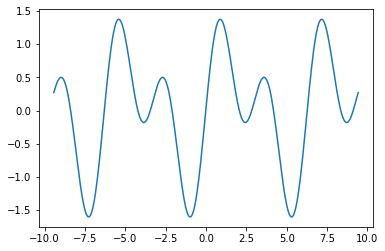

In [129]:
G=np.linspace(-3,3,301)*np.pi
def CPR(G, A, eta, C):
    return np.sin(G)+eta*np.sin(2*G)+A*np.sin(G+C*np.pi)+A*eta*np.sin(2*G+2*C*np.pi)
plt.figure()
plt.plot(G,CPR(G,A,eta,C))


### Test on a single RF current

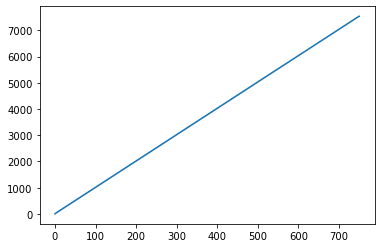

In [130]:
t=np.arange(0,300.01,0.01)/f_rf
V=np.empty([len(IDC_array)])
G_array=np.empty(len(t))
for i in range(0,len(IDC_array)):
    G_array= odeint(dGdt,0,t,args=(IDC_array[i],15,f_rf,A,eta,C))
    V[i]=np.mean(np.gradient(G_array[-10000:,0]))/(0.01/f_rf)/(2*np.pi)
DVDI=2*np.pi*np.gradient(V,IDC_step) #differential resistance dV/dI
plt.plot(t,G_array)
JV=f_rf

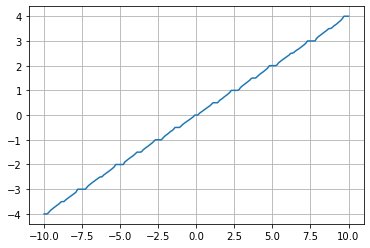

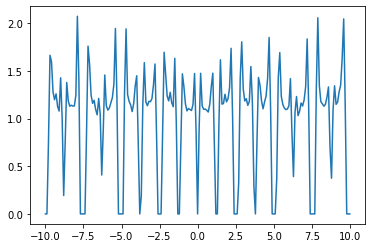

In [131]:
plt.figure()
plt.plot(IDC_array,V/JV)
plt.grid()
plt.figure()
plt.plot(IDC_array,DVDI)
#plt.ylim([0,3])

In [132]:
_name_file = "f_"+str(f_rf)+"_A"+str(np.round(A,3))+"_eta"+str(np.round(eta,3))+"_C"+str(np.round(C,2))+"pi_norm"
_name_title = "f= "+str(f_rf)+", A= "+str(np.round(A,3))+", eta= "+str(np.round(eta,3))+",C= "+str(np.round(C,2))+"pi"
print(_name_title)
T1=datetime.now()
print (T1)
V=np.empty([len(IRF_array),len(IDC_array)])
for i in range(0,len(IRF_array)):
    print("RF power now: "+str(i)+" of "+str(len(IRF_array))+" ,"+str(datetime.now()),end="\r")
    for j in range(0,len(IDC_array)):
        t=np.arange(0,300.01,0.01)/f_rf
        G_array= odeint(dGdt,0,t,args=(IDC_array[j],IRF_array[i],f_rf,A,eta,C))
        V[i,j]=np.mean(np.gradient(G_array[-10001:,0]))/(0.01/f_rf)/(2*np.pi)

DVDI=2*np.pi*np.gradient(V,IDC_step,axis=1)


print ("\n It takes " + str(datetime.now()-T1))                
        
plt.figure()
plt.pcolormesh(IDC_array, IRF_array, DVDI, cmap = 'inferno', vmin = 0,linewidth=0,rasterized=True,shading="auto")
plt.xlabel("DC Current($I/I_C$)")
plt.ylabel("RF Current ($I_RF/I_C$)")
plt.colorbar(label = "DV/DI")
plt.title(_name_title)
plt.savefig("DVDI_"+_name_file+".pdf")
plt.show()
                
plt.figure()
plt.pcolormesh(IDC_array, IRF_array, V/f_rf , cmap = 'coolwarm',linewidth=0,rasterized=True,shading="auto")
plt.xlabel("DC Current($I/I_C$)")
plt.ylabel("RF Current ($I_RF/I_C$)")
plt.colorbar(label = "$V/I_CR_N$")
plt.title(_name_title)
plt.savefig("V_"+_name_file+".pdf")
plt.show()

plt.figure()
plt.plot(IDC_array,V[1,:]/f_rf)#/(np.pi*hbar*f/Qe))
plt.show()
plt.figure()
plt.plot(IDC_array,DVDI[1,:])
plt.show()
savemat("data"+_name_file+'.mat',mdict={'IDC':IDC_array,'IRF':IRF_array,'A':A, 'eta':eta, 'f_rf':f_rf,'C':C,'V':V,'DVDI':DVDI})
print('file saved')

f= 0.4, A= 0.2, eta= 0.8,C= -0.8pi
2020-09-26 13:11:28.119589


KeyboardInterrupt: 

In [95]:
Qe=1.6e-19
Ic=2e-6
Rn=13
h=6.626e-34
f0=2*Qe*Ic*Rn/h
print(5e9/f0)

0.39819711538461544


## Plot in log of power

In [136]:
A=0.8
eta=0.6
C=-0.7 # as a unit of pi
f_rf=0.4

In [137]:
IDC_step=0.1
IDC_array=np.linspace(-10,10,201)
PRF_step=0.1
PRF_array=np.linspace(-2,3,201)
IRF_array = 10**(PRF_array/2)
print(IRF_array[-1])
print(IRF_array[0])

print("DC array size: "+str(len(IDC_array)))
print("RF array size: "+str(len(IRF_array)))



31.622776601683793
0.1
DC array size: 201
RF array size: 201


f= 0.4, A= 0.8, eta= 0.6,C= -0.7pi
2020-09-26 13:23:11.630557
RF power now: 200 of 201 ,2020-09-26 14:06:33.203092
 It takes 0:43:52.582798


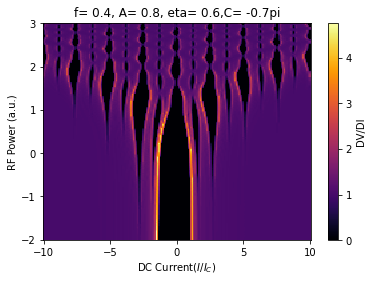

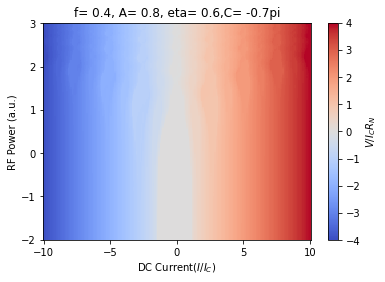

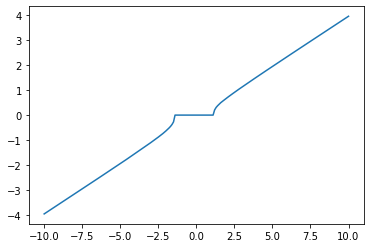

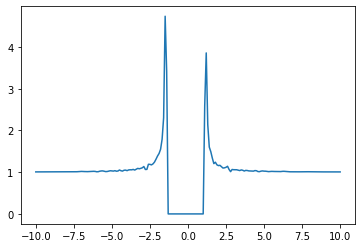

file saved


In [138]:
_name_file = "f_"+str(f_rf)+"_A"+str(np.round(A,3))+"_eta"+str(np.round(eta,3))+"_C"+str(np.round(C,2))+"pi_log"
_name_title = "f= "+str(f_rf)+", A= "+str(np.round(A,3))+", eta= "+str(np.round(eta,3))+",C= "+str(np.round(C,2))+"pi"
print(_name_title)
T1=datetime.now()
print (T1)
V=np.empty([len(IRF_array),len(IDC_array)])
for i in range(0,len(IRF_array)):
    print("RF power now: "+str(i)+" of "+str(len(IRF_array))+" ,"+str(datetime.now()),end="\r")
    for j in range(0,len(IDC_array)):
        t=np.arange(0,300.01,0.01)/f_rf
        G_array= odeint(dGdt,0,t,args=(IDC_array[j],IRF_array[i],f_rf,A,eta,C))
        V[i,j]=np.mean(np.gradient(G_array[-10001:,0]))/(0.01/f_rf)/(2*np.pi)

DVDI=2*np.pi*np.gradient(V,IDC_step,axis=1)


print ("\n It takes " + str(datetime.now()-T1))                
        
plt.figure()
plt.pcolormesh(IDC_array, PRF_array, DVDI, cmap = 'inferno', vmin = 0,linewidth=0,rasterized=True,shading="auto")
plt.xlabel("DC Current($I/I_C$)")
plt.ylabel("RF Power (a.u.)")
plt.colorbar(label = "DV/DI")
plt.title(_name_title)
plt.savefig("DVDI_"+_name_file+".pdf")
plt.show()
                
plt.figure()
plt.pcolormesh(IDC_array, PRF_array, V/f_rf , cmap = 'coolwarm',linewidth=0,rasterized=True,shading="auto")
plt.xlabel("DC Current($I/I_C$)")
plt.ylabel("RF Power (a.u.)")
plt.colorbar(label = "$V/I_CR_N$")
plt.title(_name_title)
plt.savefig("V_"+_name_file+".pdf")
plt.show()

plt.figure()
plt.plot(IDC_array,V[1,:]/f_rf)#/(np.pi*hbar*f/Qe))
plt.show()
plt.figure()
plt.plot(IDC_array,DVDI[1,:])
plt.show()
savemat("data"+_name_file+'.mat',mdict={'IDC':IDC_array,'IRF':IRF_array,'PRF':PRF_array,'A':A, 'eta':eta, 'f_rf':f_rf,'C':C,'V':V,'DVDI':DVDI})
print('file saved')

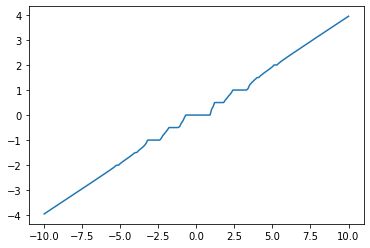

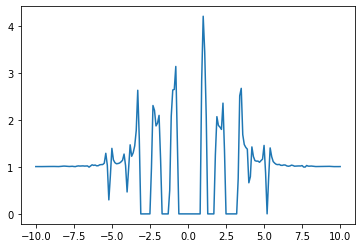

0.75


In [126]:
plt.figure()
plt.plot(IDC_array,V[130,:]/f_rf)#/(np.pi*hbar*f/Qe))
plt.show()
plt.figure()
plt.plot(IDC_array,DVDI[130,:])
plt.show()
print(PRF_array[130])

In [117]:
print(IRF_array)

[ 0.05623413  0.0578762   0.05956621  0.06130558  0.06309573  0.06493816
  0.06683439  0.06878599  0.07079458  0.07286182  0.07498942  0.07717915
  0.07943282  0.0817523   0.08413951  0.08659643  0.08912509  0.09172759
  0.09440609  0.0971628   0.1         0.10292005  0.10592537  0.10901845
  0.11220185  0.1154782   0.11885022  0.12232071  0.12589254  0.12956867
  0.13335214  0.1372461   0.14125375  0.14537844  0.14962357  0.15399265
  0.15848932  0.16311729  0.1678804   0.1727826   0.17782794  0.18302061
  0.18836491  0.19386526  0.19952623  0.2053525   0.2113489   0.2175204
  0.22387211  0.2304093   0.23713737  0.24406191  0.25118864  0.25852348
  0.26607251  0.27384196  0.28183829  0.29006812  0.29853826  0.30725574
  0.31622777  0.32546178  0.33496544  0.34474661  0.35481339  0.36517413
  0.3758374   0.38681205  0.39810717  0.40973211  0.4216965   0.43401026
  0.44668359  0.45972699  0.47315126  0.48696753  0.50118723  0.51582217
  0.53088444  0.54638655  0.56234133  0.57876199  0.